# Demo workbook exploring kernel class functionality

In [55]:
import os
import sys
import time
sys.path.append(os.path.join(os.path.abspath(""), ".."))

from app.imager import ImageLoader, DefectViewer
from app.transforms import *
from app.filters import *
from app.utils import *

In [56]:
# Load 10 images of class 'FrontGridInterruption'
n_samples = 10  # Number of samples of images
image_df = ImageLoader(defect_class='Closed') << n_samples  # Load n_sample images of class 'FrontGridInterruption'

In [57]:
# Get n_samples of the defect type 'FrontGridInterruption' and return an image array
images = DefectViewer() << image_df

## Canny filter

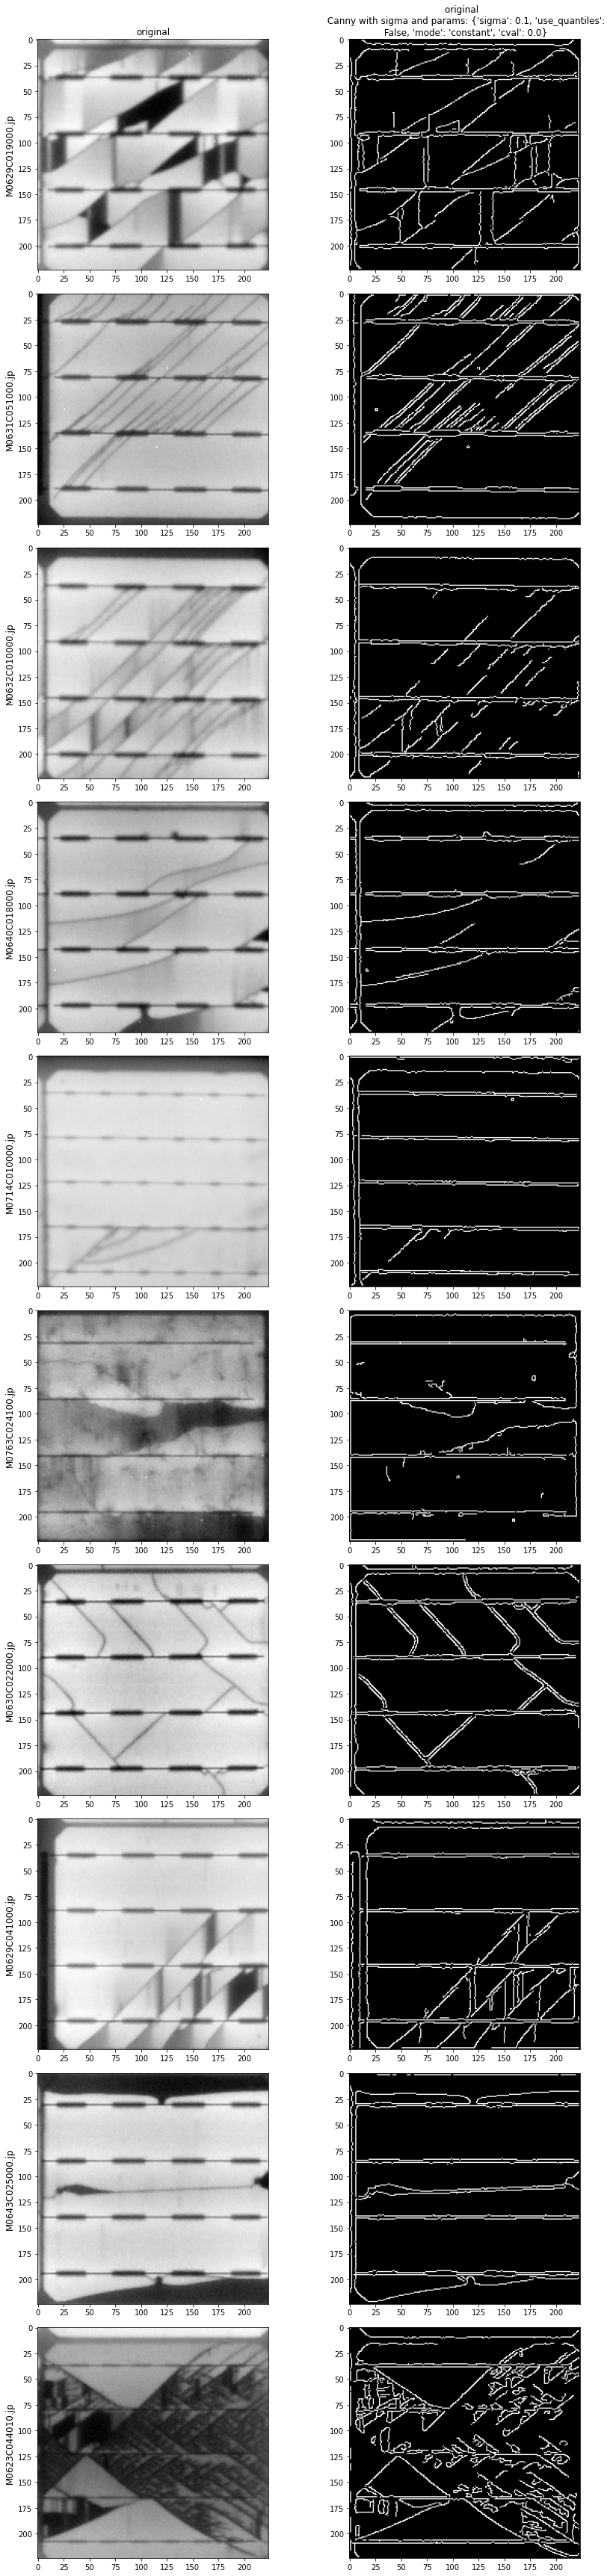

In [58]:
my_canny = Show(do_show=True) << (Canny(sigma=0.1) << images)

In [59]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(images), 1, figsize=(15,15))

for x in range(len(images)):
    X = images[x] 
    pca = PCA(n_components=3, svd_solver='full')
    X_new = pca.fit_transform(X)
    ax[x].imshow(pca.inverse_transform(X_new), cmap='Greys_r')

TypeError: object of type 'ImageWrapper' has no len()

In [66]:
from sklearn.decomposition import PCA as sk_PCA
from sklearn.preprocessing import StandardScaler
from app.utils import input_check

class PCA:
    """
    Performs Principal component analysis on either a single image or a collection
    of N images. Uses the fit_transform(X) method, Returns the inverse transform to 
    transform the data back to it's original space. 
    
    Wrapper for the sklearn implenetation
    https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

    """

    def __init__(self, transpose=True, **kwargs):
        """
        :transpose: Whether to vectorise the implementation or not. 
            if True, the image list is transformed from N x H x W (i.e. 3D)
            to N x (HxW) which enables a single function call.  
            if False, a the PCA is performed on each individual image in a 
            for loop. 
            Note when True the PCA is conducted across all images, whereas when 
            False the PCA is conducted on a single image. 
        
        :param n_components: number of components to keep. 
        :param copy: creates a new copy, default is True.

        :return:
        """
        
        self.transpose = transpose
        self.params = {}
        
        input_check(kwargs, 'n_components', None, self.params, exception=True)
        input_check(kwargs, 'copy', True, self.params, exception=False)
        input_check(kwargs, 'whiten', False, self.params, exception=False)
        input_check(kwargs, 'svd_solver', 'auto', self.params, exception=False)
        input_check(kwargs, 'tol', 0, self.params, exception=False)
        input_check(kwargs, 'iterated_power', 'auto', self.params, exception=False)
        if self.params['svd_solver'] == 'randomized':
            input_check(kwargs, 'n_oversamples', 10, self.params, exception=False)
            input_check(kwargs, 'power_iteration_normalizer', 'auto', self.params, exception=False)
            input_check(kwargs, 'random_state', None, self.params, exception=False)
        
        if kwargs:
            raise KeyError(f'Unused keyword(s) {kwargs.keys()}')

    def __lshift__(self, in_imw):
        """

        :param in_imw:
        :return:
        """

        if isinstance(in_imw, Iterable):
            # noinspection PyUnresolvedReferences
            in_imw = in_imw[-1]

        # These are the images we want to process
        in_imgs = in_imw.images
        out_imgs = self.apply(in_imgs)

        # First for the magnitude
        category = f'PCA with params {self.params}'
        category = in_imw.category + line_split_string(category)
        out_imw = ImageWrapper(out_imgs, category=category, image_labels=copy.deepcopy(in_imw.image_labels))

        return in_imw, out_imw

    def pca_transform(self, in_imgs):
        """
        Performs the dimensionality reduction, and then returns the image
        to the original space. 
        """
        pca_ = sk_PCA(**self.params)
        X_new = pca_.fit_transform(in_imgs)
        X_out = pca_.inverse_transform(X_new)
        
        return X_out
    
    def apply(self, in_imgs):
        """
        If the transpose method is specified, it transforms the image and applies the
        transform by calling the pca_transform() function. Else, we perform the 
        pca_transform() in a loop for each image. 

        """
        #Instantiate scaler instance for zero mean transform
        scaler = StandardScaler()
        
        if self.transpose == True:
            # Implenetation for 1 PCA call
            #get dimensions and reshape from (N, H, W) to (N, H*W)
            N, H, W = in_imgs.shape
            new_matrix = in_imgs.reshape(N, H * W).T
            
            # Zero mean the data
            scaler.fit(new_matrix)
            zero_meaned_matrix = scaler.transform(new_matrix)
            
            # Call function and reshape back to (N, H, W) 
            out_matrix = self.pca_transform(zero_meaned_matrix)
            
            #Apply inverse transform, transpose and reshape 
            out_imgs = scaler.inverse_transform(out_matrix).T.reshape(N, H, W)
            
        elif self.transpose == False:
            #Implementation for 1 PCA call per image
            out_list = []
            for x in in_imgs:
                
                #Scale and transform the data, then apply PCA
                out_matrix = self.pca_transform(scaler.fit_transform(x))
                
                #Appy inverse transform and append to list
                out_list.append(scaler.inverse_transform(out_matrix))
            
            out_imgs = np.stack(out_list, axis=0)

        return out_imgs

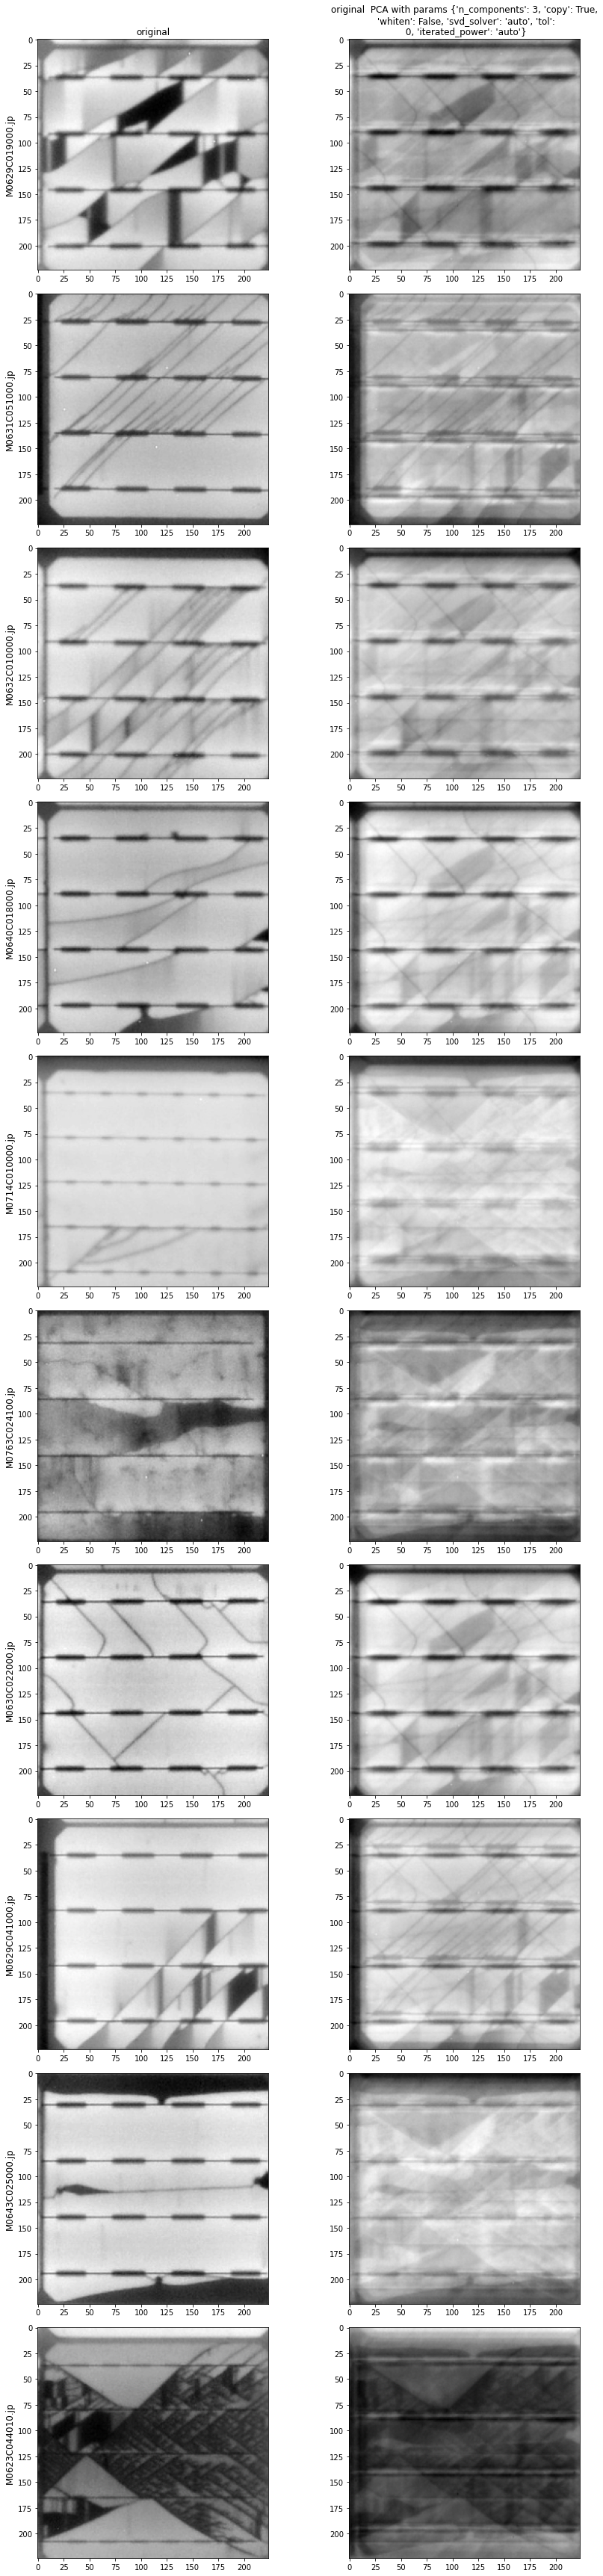

In [69]:
pca_transformed = Show(do_show=True) << (PCA(transpose=True, n_components=3) << images)

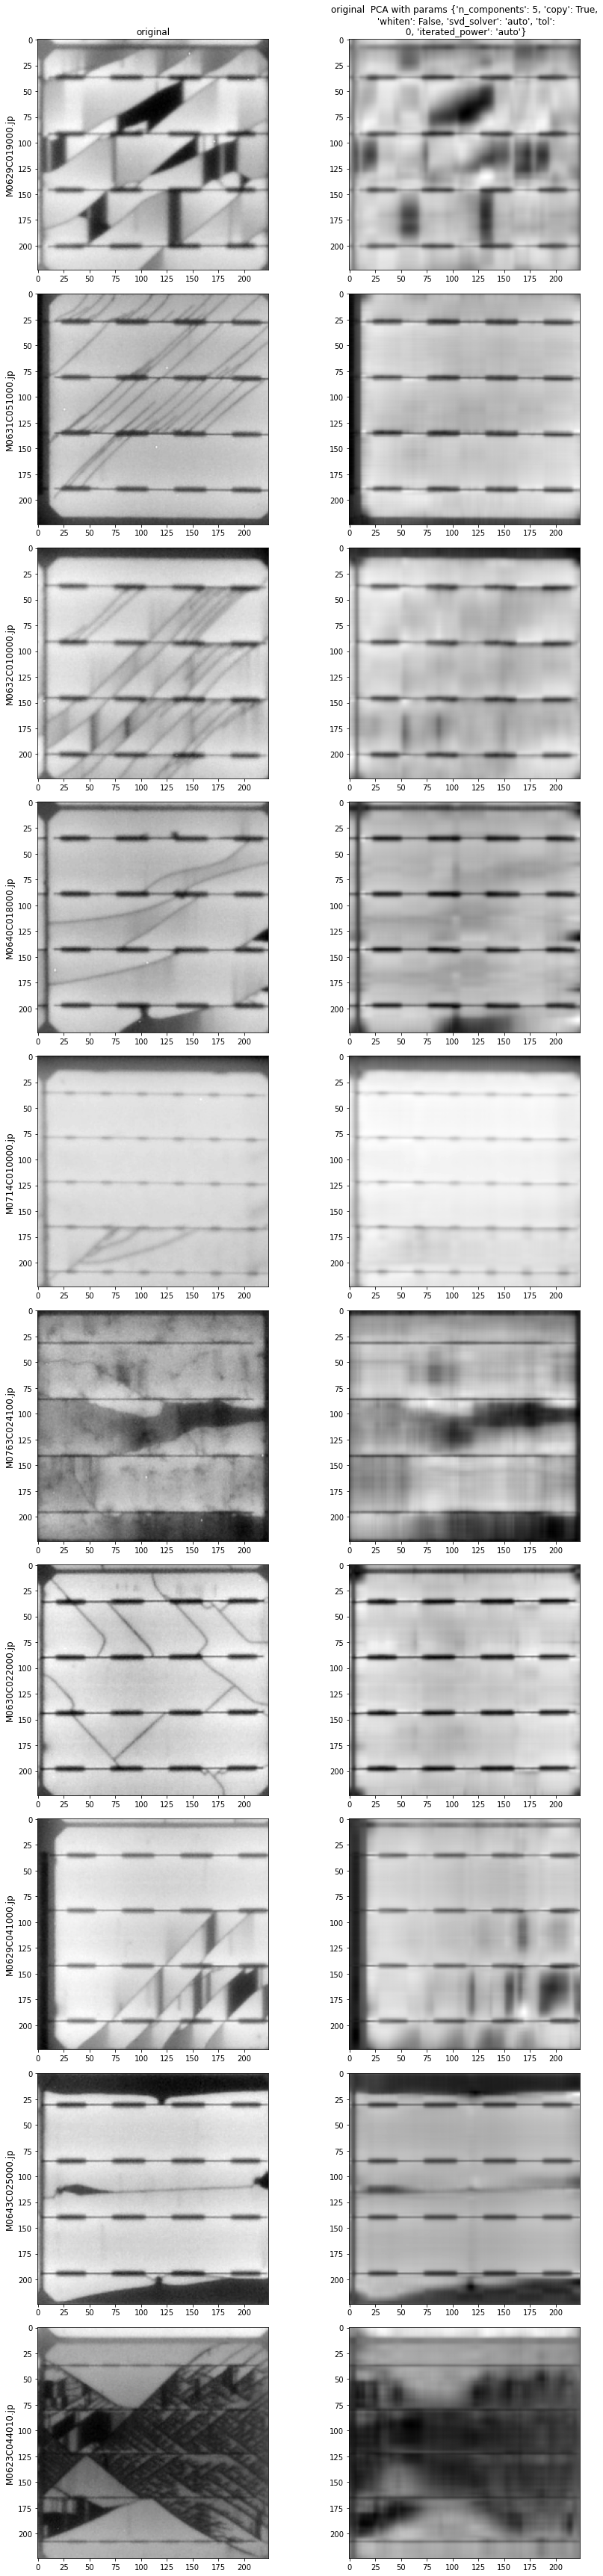

In [68]:
pca_transformed = Show(do_show=True) << (PCA(transpose=False, n_components=5) << images)